# 1. Introduction Azure ML
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

In this tutorial, you complete the end-to-end steps to get started with the Azure Machine Learning Python SDK running 
in Jupyter notebooks. 

In this tutorial, you:
- Run some Python code
- Log results into an Azure ML experiment
- Save ML models into Azure ML repository
- Use MLFlow integration with Azure ML
- Use Azure OpenDatasets

## Architecture et concepts

> https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture

<img src="https://github.com/retkowsky/images/blob/master/AzureML%20Archi.jpg?raw=true">

> Architectures Azure : https://docs.microsoft.com/en-us/azure/architecture/browse/

## 0. Paramétrage

In [65]:
import datetime
maintenant = datetime.datetime.now()
print("Aujourd'hui :", maintenant)

Aujourd'hui : 2020-09-22 11:56:34.812323


In [66]:
import scipy, matplotlib, pandas, sklearn
import numpy as np
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [67]:
import sys
print("Version Python =", sys.version)

Version Python = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [68]:
print("Versions :")
print('- scipy = {}'.format(scipy.__version__))
print('- numpy = {}'.format(np.__version__))
print('- matplotlib = {}'.format(matplotlib.__version__))
print('- pandas = {}'.format(pandas.__version__))
print('- sklearn = {}'.format(sklearn.__version__))
print("- Azure ML =",azureml.core.VERSION)

Versions :
- scipy = 1.4.1
- numpy = 1.16.2
- matplotlib = 3.2.2
- pandas = 0.25.3
- sklearn = 0.20.3
- Azure ML = 1.13.0


> Versions azure ML : https://docs.microsoft.com/en-us/azure/machine-learning/azure-machine-learning-release-notes

In [69]:
# Rappel des infos du workspace Azure ML service
from azureml.core import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: workshopAML2020
Azure region: westeurope
Resource group: workshopAML2020-rg


## 1. Chargement des données

In [70]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

In [71]:
# scikit-learn version
import sklearn
print("Version scikit-learn =", sklearn.__version__)

Version scikit-learn = 0.20.3


> https://scikit-learn.org/stable/index.html

#### Données : DIABETES
From Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499, we have

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."
> https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

In [72]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [73]:
# Taille en % de la base de test
testsizepct=0.30

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsizepct, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [75]:
nobstrain=len(data['train']['X'])
nobstest=len(data['test']['X'])
print ("Training =", nobstrain, 'observations')
print ("Test =", nobstest, 'observations')

Training = 309 observations
Test = 133 observations


## 2. Modélisation

Nous allons réaliser un modèle de régression **Ridge**.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>
C'est une version régularisée de la régression linéaire.
Particulièrement utile lorsque les covariables sont fortement autocorrélées.

Cela permet d'ajuster les données avec des coefficents de pondération du modèle les plus petits possibles.
- Si le paramétre = 0 => nous avons dans ce cas une régression linéaire.
- Si le paramétre a une valeur importante, alors les coefficients de pondérations ont des valeurs proches de 0 => on aura dans ce cas une ligne horizontale qui passe par la moyenne des données.



> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### Création expérimentation Azure ML

In [76]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name="Exemple1-Intro")

Les étapes
1. Logs d'informations
2. Modélisation
3. Logs de résultats de modèles et graphiques
4. Sauvegarde modèle

In [88]:
def regridge(k):
    
    # 1. On démarre le logging des informations
    run = experiment.start_logging(snapshot_directory=None)
    
    print('k =', k)
    print()    
       
    # 2. Logs d'informations au run
    run.log('k', k) # On loggue la valeur de k dans l'expérimentation Azure ML
    run.log('Test Size', testsizepct) # On loggue la valeur dans l'expérimentation Azure ML
    run.log('Nobs Training', nobstrain) # On loggue la valeur dans l'expérimentation Azure ML
    run.log('Nobs Test', nobstest) # On loggue la valeur dans l'expérimentation Azure ML
    
    print('Test Size =', testsizepct)
    print('Nombre observations Training =', nobstrain)
    print('Nombre observations Test =', nobstest)    
    print()
    
    # 3. Construction d'un modèle de régression Ridge avec la valeur de k comme hyperparamètre
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Log de la métrique Mean Squared Error du modèle dans l'expérimentation
    from sklearn.metrics import r2_score
    import math
    
    mse = mean_squared_error(data['test']['y'], preds)
    rmse = math.sqrt(mse)
    R2 = r2_score(data['test']['y'], preds)
    
    print('- RMSE =', rmse)
    print('- MSE =', mse)
    print('- R2 =', R2)
    
    run.log("rmse", rmse)
    run.log('mse', mse)
    run.log('R2', R2)

    # 5. Export modèle pour chaque valeur de k
    
    model_name = "RegRidgeModele-k-" + str(k) + ".pkl"
    filename = "outputs/" + model_name
    joblib.dump(value=regression_model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    
    # 6. Ajout de tags personnalisés au run
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AzureML", "1.1.13")
    run.tag("Team", "DataScience France")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 7. Création et log d'un graphique
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    
    fig.savefig("RegRidgeGraphique-k-"+str(k)+".png") # On sauvegarde chaque graphique avec un nom personnalisé
    plt.title('Ajustement Régression Ridge', fontsize=10)
    
    run.log_image(name='Ajustement Régression Ridge', plot=plt) # On loggue dans l'expérimentation l'image du graphique
    
    # 6. Fin du run
    run.complete()

### On réalise plusieurs appels de la fonction REGRIDGE

k = 0

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.65200929335614
- MSE = 3097.1461383877977
- R2 = 0.3928939845074757


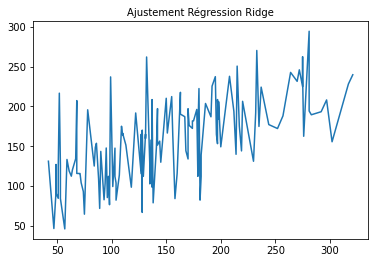

In [89]:
regridge(0)

k = 0.1

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.227098269942545
- MSE = 3050.0323833178904
- R2 = 0.4021292749449723


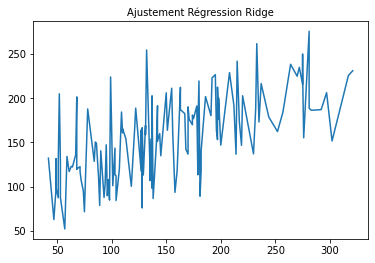

In [90]:
regridge(0.1)

k = 0.2

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.015159130262695
- MSE = 3026.667734128127
- R2 = 0.4067092393506434


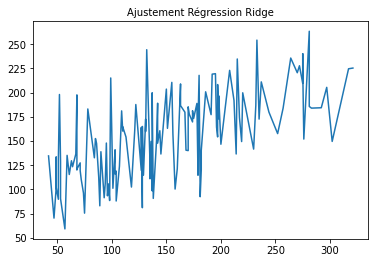

In [91]:
regridge(0.2)

k = 0.3

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.052105254959926
- MSE = 3030.734293003186
- R2 = 0.40591210797708555


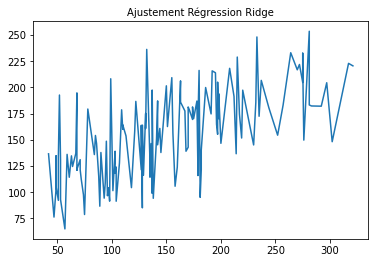

In [92]:
regridge(0.3)

k = 0.4

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.22012756388052
- MSE = 3049.262488171237
- R2 = 0.40228019064411824


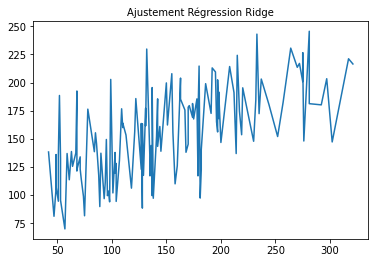

In [93]:
regridge(0.4)

k = 0.5

Test Size = 0.3
Nombre observations Training = 309
Nombre observations Test = 133

- RMSE = 55.45784630670391
- MSE = 3075.5727169779925
- R2 = 0.39712283046030694


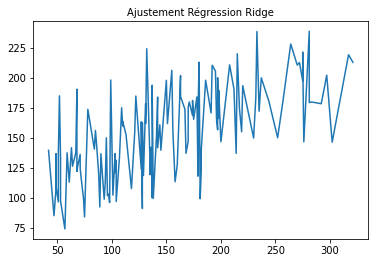

In [94]:
regridge(0.5)

In [95]:
# Liste des pickle des modèles sauvegardés sur le disque
%ls outputs/RegRidgeModele*.pkl -l

-rwxrwxrwx 1 root root 627 Sep 22 12:04 outputs/RegRidgeModele-k-0.1.pkl*
-rwxrwxrwx 1 root root 627 Sep 22 12:04 outputs/RegRidgeModele-k-0.2.pkl*
-rwxrwxrwx 1 root root 627 Sep 22 12:04 outputs/RegRidgeModele-k-0.3.pkl*
-rwxrwxrwx 1 root root 627 Sep 22 12:05 outputs/RegRidgeModele-k-0.4.pkl*
-rwxrwxrwx 1 root root 627 Sep 22 12:05 outputs/RegRidgeModele-k-0.5.pkl*
-rwxrwxrwx 1 root root 620 Sep 22 12:04 outputs/RegRidgeModele-k-0.pkl*


In [96]:
# Liste des graphiques sauvegardés sur le disque
%ls RegRidgeGraphique*.png -l

-rwxrwxrwx 1 root root 24471 Sep 22 12:04 RegRidgeGraphique-k-0.1.png*
-rwxrwxrwx 1 root root 26538 Sep 22 12:04 RegRidgeGraphique-k-0.2.png*
-rwxrwxrwx 1 root root 26890 Sep 22 12:04 RegRidgeGraphique-k-0.3.png*
-rwxrwxrwx 1 root root 27243 Sep 22 12:05 RegRidgeGraphique-k-0.4.png*
-rwxrwxrwx 1 root root 27150 Sep 22 12:05 RegRidgeGraphique-k-0.5.png*
-rwxrwxrwx 1 root root 25004 Sep 22 12:04 RegRidgeGraphique-k-0.png*


## Référencement du modèle

Le meilleur modèle est pour k=0.2.

In [97]:
monmodele='RegRidgeModele-k-0.2.pkl'
k=0.2
RMSE = 55.015159130262695
MSE = 3026.667734128127
R2 = 0.4067092393506434

In [98]:
from azureml.core.model import Model

model = Model.register(model_path="outputs/"+monmodele, # Référence du pickle
                       model_name="DiabetesRidge", # Nom du modèle référencé
                       model_framework=Model.Framework.SCIKITLEARN,  # Framework
                       model_framework_version='0.20.3',             # Version scikit-learn
                       tags={'area': 'Diabetes', # Ajout de tags au modèle
                             'type': 'Regression Ridge', 
                             'k':k, 
                             'MSE' : MSE, 
                             'R2' : R2,
                             'RMSE' : RMSE,
                             'Framework' : 'Azure ML SDK'},
                       description="Modèle de régression Ridge", # Description du modèle
                       workspace=ws) # Nom du workspace Azure ML

Registering model DiabetesRidge


Le modèle est référencé dans le référentiel des modèles Azure ML.

## Informations du modèle référencé

In [99]:
print('Nom du modèle :', model.name)
print('Description :', model.description)
print('ID =', model.id)
print('Version =', model.version)

Nom du modèle : DiabetesRidge
Description : Modèle de régression Ridge
ID = DiabetesRidge:11
Version = 11


## On visualise les métriques pour chaque run

In [100]:
# Liste des métriques par Run
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['Exemple1-Diabetes']
for logged_run in diabetes_experiment.get_runs():
    print()
    print('Run ID :', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))


Run ID : 75d966cf-7181-439c-a1c5-4edbfc5264f6

Run ID : 7bfeea31-a6be-4f56-afd1-8662cd0ebe58

Run ID : 50b75027-9a88-4be1-b9ea-657f45ca305f
- k 0.5
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- rmse 57.43613501800989
- mse 3298.9096058070622
- R2 0.35667773997495866
- Ajustement Régression Ridge aml://artifactId/ExperimentRun/dcid.50b75027-9a88-4be1-b9ea-657f45ca305f/Ajustement Régression Ridge_1595351621.png

Run ID : 86811847-4b53-4d26-883e-acc4fe2cfb67
- k 0.4
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- rmse 57.40854522068826
- mse 3295.741064355809
- R2 0.3572956390661659
- Ajustement Régression Ridge aml://artifactId/ExperimentRun/dcid.86811847-4b53-4d26-883e-acc4fe2cfb67/Ajustement Régression Ridge_1595351557.png

Run ID : 0fdd8e70-803f-4bca-b85c-4a226fbcb613
- k 0.3
- Test Size 0.2
- Nobs Training 353
- Nobs Test 89
- rmse 57.46889274556911
- mse 3302.6736334017255
- R2 0.35594371478835374
- Ajustement Régression Ridge aml://artifactId/ExperimentRun/dcid.0fdd8e7

Nous pouvons visualiser les résultats sur le portail dans la section **experiments** :

In [101]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Intro,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


## 3. Utilisation MLFlow

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/how-to-use-mlflow/mlflow-diagram-track.png">

Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-use-mlflow

> https://mlflow.org/

In [102]:
import mlflow
import mlflow.sklearn
import azureml.core
from azureml.core import Workspace
import matplotlib.pyplot as plt

In [103]:
# A installer si besoin
#!pip install azureml-mlflow

In [104]:
ws = Workspace.from_config()

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

experiment_name = "Exemple1-MLFlow"
mlflow.set_experiment(experiment_name)

Données : 353 observations d'apprentissage et 89 observations de test.
k = 0.4
Mean Squared Error = 3295.741064355809


2020/09/22 12:07:11 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under azureml://experiments/Exemple1-MLFlow/runs/cea18ec9-7c4e-4821-8f98-404dba1a1021/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the  tracking store. If logging to a mlflow server via REST, consider  upgrading the server version to MLflow 1.7.0 or above.


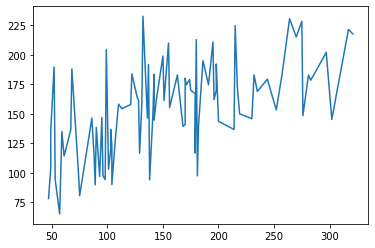

In [105]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Données :", len(data['train']['X']), "observations d'apprentissage et",len(data['test']['X']), "observations de test.")

model_save_path = "model"

k=0.4

with mlflow.start_run() as run:
    
    mlflow.log_metric('k', k)
    print('k =', k)
    
    regression_model = Ridge(alpha=k)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    print('Mean Squared Error =', mean_squared_error(data['test']['y'], preds))
    mlflow.log_metric('mse', mean_squared_error(data['test']['y'], preds))
    
    mlflow.sklearn.log_model(regression_model,model_save_path)
    
    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    fig.savefig("GraphiqueMLFlow.png")
    mlflow.log_artifact("GraphiqueMLFlow.png")
    

In [106]:
ws.experiments[experiment_name]

Name,Workspace,Report Page,Docs Page
Exemple1-MLFlow,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


## 4. Autres exemples

In [107]:
experiment = Experiment(workspace=ws, name='Exemple1-Logging')

In [108]:
from tqdm import tqdm

In [109]:
# start logging for the run
run = experiment.start_logging(snapshot_directory=None)

# change the scale factor on different runs to see how you can compare multiple runs
scale_factor = 3.14

# change the category on different runs to see how to organize data in reports
category = 'Pi'

In [110]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple1-Logging,cae2fd46-415a-4bc3-8467-428e6f2c03d0,,Running,Link to Azure Machine Learning studio,Link to Documentation


In [111]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


In [112]:
# log chaine de caractères
run.log(name='Category', value=category)

In [113]:
# log donneés numériques
run.log(name="scale factor", value = scale_factor)
run.log(name='Magic Number', value=42 * scale_factor)

In [114]:
fibonacci_values = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
scaled_values = (i * scale_factor for i in fibonacci_values)

# Log a list of values. Note this will generate a single-variable line chart.
run.log_list(name='Fibonacci', value=scaled_values)

for i in tqdm(range(-10, 10)):
    # log a metric value repeatedly, this will generate a single-variable line chart.
    run.log(name='Sigmoid', value=1 / (1 + np.exp(-i)))

100%|██████████| 20/20 [00:00<00:00, 7298.25it/s]


In [115]:
# create a dictionary to hold a table of values
sines = {}
sines['angle'] = []
sines['sine'] = []

for i in tqdm(range(-10, 10)):
    angle = i / 2.0 * scale_factor
    
    # log a 2 (or more) values as a metric repeatedly. This will generate a 2-variable line chart if you have 2 numerical columns.
    run.log_row(name='Cosine Wave', angle=angle, cos=np.cos(angle))
        
    sines['angle'].append(angle)
    sines['sine'].append(np.sin(angle))

# log a dictionary as a table, this will generate a 2-variable chart if you have 2 numerical columns
run.log_table(name='Sine Wave', value=sines)

100%|██████████| 20/20 [00:00<00:00, 7095.76it/s]


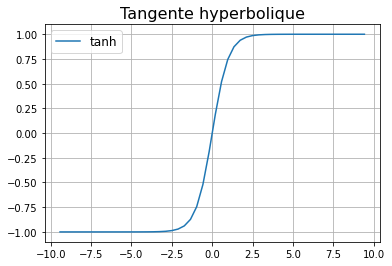

In [116]:
%matplotlib inline

import matplotlib.pyplot as plt
angle = np.linspace(-3, 3, 50) * scale_factor
plt.plot(angle,np.tanh(angle), label='tanh')
plt.legend(fontsize=12)
plt.title('Tangente hyperbolique', fontsize=16)
plt.grid(True)

run.log_image(name='Tangente hyperbolique', plot=plt)

In [117]:
file_name = 'outputs/myfile.txt'

with open(file_name, "w") as f:
    f.write('This is an output file that will be uploaded.\n')

# Upload the file explicitly into artifacts 
run.upload_file(name = file_name, path_or_stream = file_name)

In [118]:
run.complete()

In [119]:
experiment

Name,Workspace,Report Page,Docs Page
Exemple1-Logging,workshopAML2020,Link to Azure Machine Learning studio,Link to Documentation


In [120]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['Exemple1-Logging']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))


Run ID: cae2fd46-415a-4bc3-8467-428e6f2c03d0
- Tangente hyperbolique aml://artifactId/ExperimentRun/dcid.cae2fd46-415a-4bc3-8467-428e6f2c03d0/Tangente hyperbolique_1600776443.png
- Category Pi
- scale factor 3.14
- Magic Number 131.88
- Fibonacci [0.0, 3.14, 3.14, 6.28, 9.42, 15.700000000000001, 25.12, 40.82, 65.94, 106.76, 172.70000000000002, 279.46000000000004]
- Sigmoid [4.5397868702434395e-05, 0.00012339457598623172, 0.0003353501304664781, 0.0009110511944006454, 0.0024726231566347743, 0.0066928509242848554, 0.01798620996209156, 0.04742587317756678, 0.11920292202211755, 0.2689414213699951, 0.5, 0.7310585786300049, 0.8807970779778823, 0.9525741268224334, 0.9820137900379085, 0.9933071490757153, 0.9975273768433653, 0.9990889488055994, 0.9996646498695336, 0.9998766054240137]
- Cosine Wave {'angle': [-15.700000000000001, -14.13, -12.56, -10.99, -9.42, -7.8500000000000005, -6.28, -4.71, -3.14, -1.57, 0.0, 1.57, 3.14, 4.71, 6.28, 7.8500000000000005, 9.42, 10.99, 12.56, 14.13], 'cos': [-0.9

## 5. Azure Open Datasets

Mise à disposition d'open data dans Azure.
Azure ML permet d'accéder à ces open datasets.

<img src="https://github.com/retkowsky/images/blob/master/opendata.jpg?raw=true">

> https://azure.microsoft.com/fr-fr/services/open-datasets/

In [121]:
#!pip install azureml-opendatasets

In [122]:
# Dataset jours fériés
from azureml.opendatasets import PublicHolidays

from datetime import datetime
from dateutil import parser
from dateutil.relativedelta import relativedelta

In [123]:
# Intervalle en mois
mois=12

In [124]:
import time
datedujour = time.strftime("%d-%m-%Y")
print("Date :", datedujour)

Date : 22-09-2020


In [125]:
fin = datetime.today() + relativedelta(months=mois)
debut = datetime.today() - relativedelta(months=mois)

In [126]:
print("Début :", debut)
print("Fin :", fin)

Début : 2019-09-22 12:07:44.258882
Fin : 2021-09-22 12:07:44.258712


In [127]:
hol = PublicHolidays(start_date=debut, end_date=fin)
joursferies = hol.to_pandas_dataframe()

[Info] read from /tmp/tmpwbmgsgec/https%3A/%2Fazureopendatastorage.azurefd.net/holidaydatacontainer/Processed/part-00000-tid-1744422316179224954-2cd4580c-2bf8-4ad7-9568-a4bd34746b1f-649-c000.snappy.parquet


In [128]:
joursferies.shape

(1099, 6)

In [129]:
joursferies.head(15)

,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode,date
25781,Japan,秋分の日,秋分の日,None,JP,2019-09-23
25782,South Africa,Heritage Day,Heritage Day,None,ZA,2019-09-24
25783,Czech,Den české státnosti,Den české státnosti,None,CZ,2019-09-28
25784,Norway,Søndag,Søndag,None,NO,2019-09-29
25785,Sweden,Söndag,Söndag,None,SE,2019-09-29
25786,India,Gandhi Jayanti,Gandhi Jayanti,True,IN,2019-10-02
25787,Germany,Tag der Deutschen Einheit,Tag der Deutschen Einheit,None,DE,2019-10-03
25788,Portugal,Implantação da República,Implantação da República,None,PT,2019-10-05
25789,Norway,Søndag,Søndag,None,NO,2019-10-06
25790,Sweden,Söndag,Söndag,None,SE,2019-10-06


In [130]:
# Pour avoir les jours féries en France
joursferiesFR=joursferies[joursferies.countryRegionCode == 'FR']

In [131]:
# Pour avoir la colonne date en 1ere colonne
joursferiesFR = joursferiesFR[ ['date'] + [ col for col in joursferiesFR.columns if col != 'date' ] ]

In [132]:
print("Nombre de jours fériés sur la période :", len(joursferiesFR.index), "jours.")

Nombre de jours fériés sur la période : 22 jours.


In [133]:
joursferiesFR

,date,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode
25816,2019-11-01,France,Toussaint,Toussaint,None,FR
25836,2019-11-11,France,Armistice 1918,Armistice 1918,None,FR
25886,2019-12-25,France,Noël,Noël,None,FR
25951,2020-01-01,France,Jour de l'an,Jour de l'an,None,FR
26100,2020-04-13,France,Lundi de Pâques,Lundi de Pâques,None,FR
26142,2020-05-01,France,Fête du Travail,Fête du Travail,None,FR
26169,2020-05-08,France,Armistice 1945,Armistice 1945,None,FR
26186,2020-05-21,France,Ascension,Ascension,None,FR
26215,2020-06-01,France,Lundi de Pentecôte,Lundi de Pentecôte,None,FR
26268,2020-07-14,France,Fête nationale,Fête nationale,None,FR


In [134]:
# Export fichier CSV
joursferiesFR.to_csv(r'exportjoursferies.csv', index = False)

In [135]:
# Export fichier EXCEL
joursferiesFR.to_excel('exportjoursferies.xlsx')  

In [136]:
%ls exportjoursferies.* -l

-rwxrwxrwx 1 root root 1170 Sep 22 12:07 exportjoursferies.csv*
-rwxrwxrwx 1 root root 6280 Sep 22 12:07 exportjoursferies.xlsx*


In [137]:
# Visu du fichier csv exporté
with open(os.path.join('./exportjoursferies.csv'), 'r') as f:
    print(f.read())

date,countryOrRegion,holidayName,normalizeHolidayName,isPaidTimeOff,countryRegionCode
2019-11-01,France,Toussaint,Toussaint,,FR
2019-11-11,France,Armistice 1918,Armistice 1918,,FR
2019-12-25,France,Noël,Noël,,FR
2020-01-01,France,Jour de l'an,Jour de l'an,,FR
2020-04-13,France,Lundi de Pâques,Lundi de Pâques,,FR
2020-05-01,France,Fête du Travail,Fête du Travail,,FR
2020-05-08,France,Armistice 1945,Armistice 1945,,FR
2020-05-21,France,Ascension,Ascension,,FR
2020-06-01,France,Lundi de Pentecôte,Lundi de Pentecôte,,FR
2020-07-14,France,Fête nationale,Fête nationale,,FR
2020-08-15,France,Assomption,Assomption,,FR
2020-11-01,France,Toussaint,Toussaint,,FR
2020-11-11,France,Armistice 1918,Armistice 1918,,FR
2020-12-25,France,Noël,Noël,,FR
2021-01-01,France,Jour de l'an,Jour de l'an,,FR
2021-04-05,France,Lundi de Pâques,Lundi de Pâques,,FR
2021-05-01,France,Fête du Travail,Fête du Travail,,FR
2021-05-08,France,Armistice 1945,Armistice 1945,,FR
2021-05-13,France,Ascension,Ascension,,FR
2021-0

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">